In [1]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define data transform
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
])

# Create training and validation split of data
train_split = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_split = datasets.MNIST('./data', train=False, download=True, transform=transform)

# create dataloaders for train and test splits
train_dataloader = DataLoader(train_split, shuffle=True, batch_size=50, num_workers=1)
test_dataloader = DataLoader(test_split, shuffle=False, batch_size=50, num_workers=1)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



0 torch.Size([50, 1, 28, 28]) torch.Size([50])


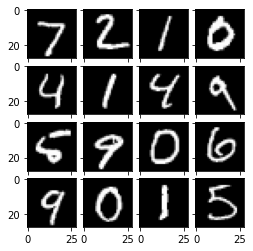

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# get batch from dataloader
sampler = enumerate(test_dataloader)
batch_idx, (x, y) = next(sampler)
print(batch_idx, x.shape, y.shape)

# select sample images
images = [x[i].squeeze().numpy() for i in range(16)]

# create and display plot
fig = plt.figure()
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 4),
                 axes_pad=0.1,
)
for axis, image in zip(grid, images):
    # Iterating over the grid returns the Axes.
    axis.imshow(image, cmap='gray')

plt.show() 

# 0, 1, 2, 3, 4, 5, 6, 7, 8, 9

In [13]:
import torch
import torch.nn as nn # shift+enter

# define model using torch.nn
class MLP(nn.Module):
  def __init__(self, input_size=28*28, hidden_size=32, output_size=10):
    super(MLP, self).__init__()

    # define layers
    self.layer_1 = nn.Linear(in_features=input_size, out_features=hidden_size)
    self.layer_2 = nn.Linear(in_features=hidden_size, out_features=hidden_size)
    self.layer_3 = nn.Linear(in_features=hidden_size, out_features=output_size)

    # define activations
    self.act = nn.Sigmoid()
    # self.tanh = nn.Tanh()


  def forward(self, x):
    x = torch.flatten(x, start_dim=1, end_dim=-1)
    
    h_1 = self.layer_1(x)
    a_1 = self.act(h_1)

    h_2 = self.layer_2(a_1)
    a_2 = self.act(h_2)

    y = self.layer_3(a_2)
    y = self.act(y)

    return y

# (one hot encoding)
# 0 : [1, 0, 0, 0, 0, 0, ....]
# 1 : [0, 1, 0, 0, 0, 0, ....]
# 2 : [0, 0, 1, 0, 0, 0 ....]

# 2 classes, cats and dogs
# Cats : [1, 0]
# Dogs : [0, 1]

In [17]:
import torch.optim as optim
from torch.nn.functional import one_hot

# hyperparameters
num_epochs = 25
lr = 1

# create model, optimizer, and loss function
model = MLP(input_size=28*28, hidden_size=64, output_size=10).to('cuda')
optimizer = optim.SGD(model.parameters(), lr=lr)
mse_loss = nn.MSELoss() # 1/N * sum((pred - y)**2)

# define the training and test steps
def train(model, optimizer, dataloader):
  model.train()
  losses = []
  accuracies = []
  for batch_idx, (x, y) in enumerate(dataloader):
    x, y = x.to('cuda'), y.to('cuda')
    optimizer.zero_grad()

    pred = model(x)
    loss = mse_loss(pred, one_hot(y, num_classes=10).float())
    loss.backward()
    optimizer.step()

    accuracy = torch.mean((torch.argmax(pred, dim=-1) == y).float())

    losses.append(loss.detach().cpu())
    accuracies.append(accuracy.cpu())

  return torch.mean(torch.stack(losses, dim=0)), torch.mean(torch.stack(accuracies, dim=0))

def test(model, optimizer, dataloader):
  model.eval()
  losses = []
  accuracies = []
  for batch_idx, (x, y) in enumerate(dataloader):
    x, y = x.to('cuda'), y.to('cuda')

    pred = model(x)
    loss = mse_loss(pred, one_hot(y, num_classes=10).float())

    accuracy = torch.mean((torch.argmax(pred, dim=-1) == y).float())

    losses.append(loss.detach().cpu())
    accuracies.append(accuracy.cpu())
    
  return torch.mean(torch.stack(losses, dim=0)), torch.mean(torch.stack(accuracies, dim=0))

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
for epoch in range(num_epochs):
  train_loss, train_accuracy = train(model, optimizer, train_dataloader)
  test_loss, test_accuracy = test(model, optimizer, test_dataloader)

  print(f'Train loss: {train_loss.item():.2f}, Train Accuracy: {train_accuracy.item():.2f}, Test loss: {test_loss.item():.2f}, Test Accuracy: {test_accuracy.item():.2f}')

  train_losses.append(train_loss.item())
  test_losses.append(test_loss.item())
  train_accuracies.append(train_accuracy.item())
  test_accuracies.append(test_accuracy.item())

Train loss: 0.09, Train Accuracy: 0.26, Test loss: 0.07, Test Accuracy: 0.44
Train loss: 0.05, Train Accuracy: 0.65, Test loss: 0.04, Test Accuracy: 0.77
Train loss: 0.03, Train Accuracy: 0.84, Test loss: 0.02, Test Accuracy: 0.89
Train loss: 0.02, Train Accuracy: 0.90, Test loss: 0.02, Test Accuracy: 0.91
Train loss: 0.02, Train Accuracy: 0.91, Test loss: 0.01, Test Accuracy: 0.92
Train loss: 0.01, Train Accuracy: 0.92, Test loss: 0.01, Test Accuracy: 0.93
Train loss: 0.01, Train Accuracy: 0.93, Test loss: 0.01, Test Accuracy: 0.93
Train loss: 0.01, Train Accuracy: 0.93, Test loss: 0.01, Test Accuracy: 0.93
Train loss: 0.01, Train Accuracy: 0.94, Test loss: 0.01, Test Accuracy: 0.94
Train loss: 0.01, Train Accuracy: 0.94, Test loss: 0.01, Test Accuracy: 0.94
Train loss: 0.01, Train Accuracy: 0.95, Test loss: 0.01, Test Accuracy: 0.94
Train loss: 0.01, Train Accuracy: 0.95, Test loss: 0.01, Test Accuracy: 0.95
Train loss: 0.01, Train Accuracy: 0.95, Test loss: 0.01, Test Accuracy: 0.95

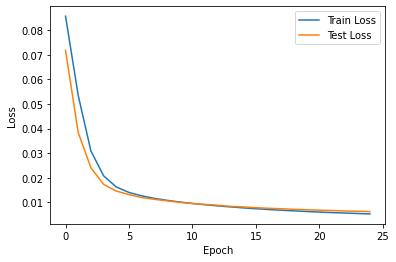

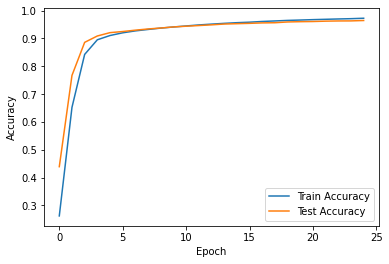

In [18]:
# plot loss and accuracy

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

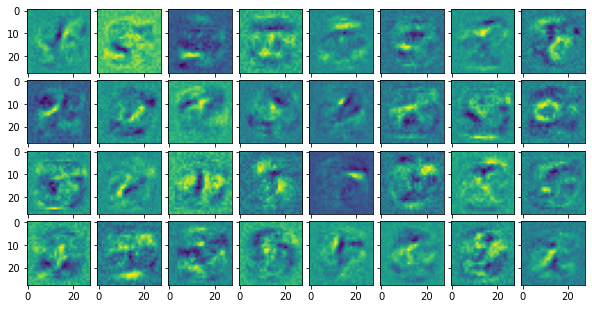

In [20]:
# visualize weights of first layer
# select weights and reshape to image
images = [model.layer_1.weight[i].detach().reshape(28, 28).cpu().numpy() for i in range(32)]

# create and display plot
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 8),
                 axes_pad=0.1,
)
for axis, image in zip(grid, images):
    # Iterating over the grid returns the Axes.
    axis.imshow(image)

plt.show()